In [ ]:
# revisiting testing the debalzing for specific weird stars HIP111169, HIP109427, and HIP113963

In [1]:
import import_ipynb
from bstar_deblaze import bstar_deblazed2
from bstar_deblaze import flats_deblazed2
from bstar_deblaze import median_fit_deblazed2
from bstar_deblaze import percentile_fit_deblazed
from bstar_deblaze import bstar_deblazed_detrend
from bstar_deblaze import zoe_percentile_deblazed
from rescale import get_rescaled_wave_soln
from resample_then_combine_orders import resample_order
from ALSFS import ALSFS
from AFS import AFS
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
all_bstar_blaze = pd.read_csv('bstar_blaze_funcs.csv').iloc[:,1:].values
all_flats_blaze = pd.read_csv('flats_blaze_funcs.csv').iloc[:,1:].values

importing Jupyter notebook from bstar_deblaze.ipynb
importing Jupyter notebook from rescale.ipynb
importing Jupyter notebook from resample_then_combine_orders.ipynb


In [5]:
def visualize_preprocessing(filenames, name):

    # Sum all of the data files for a star
    data = np.zeros((79, 4608))

    for filename in filenames:
        file = pf.open(path_name + '/' + filename)
        data_part = file[0].data
        if (str(np.shape(data_part)) != '(79, 4608)'):
            print(str(np.shape(data_part)) + ' is an incompatible data shape.')
            print('Cannot perform shift-and-match process.')
            sys.exit()
        try:
            data += data_part
        except ValueError:
            ve = True

    data_deb_bstar = np.copy(data)/np.percentile(data,99)
    data_deb_flats = np.copy(data)/np.percentile(data,99)
    data_deb_med_filt = np.copy(data)/np.percentile(data,99)
    data_deb_pcnt_filt = np.copy(data)/np.percentile(data,99)
    data_deb_bstar_det = np.copy(data)/np.percentile(data,99)
    data_deb_zoe_pcnt = np.copy(data)/np.percentile(data,99)
    data_deb_ALSFS = np.copy(data)/np.percentile(data,99)
    data_deb_AFS = np.copy(data)/np.percentile(data,99)
    median_filt_blaze = np.zeros(np.shape(data))
    pcnt_filt_blaze = np.zeros(np.shape(data))
    bstar_det_blaze = np.zeros(np.shape(data))
    linear_trends = np.zeros(np.shape(data))
    zoe_pcnt_blaze = np.zeros(np.shape(data))
    ALSFS_blaze = np.zeros(np.shape(data))
    AFS_blaze = np.zeros(np.shape(data))
    for order_inc in range(22):  
        #print(order_inc)
        # prepare data for input into ALSFS algorithm
        #order_data_arr = np.vstack([wave_soln[30 + order_inc][:4600], data[30 + order_inc][:4600]]).T
        # NOTE: make copy for ALSFS and AFS separatley because modif-ed in the function
        order_data_ALSFS = pd.DataFrame(np.vstack([wave_soln[30 + order_inc][:4600], data[30 + order_inc][:4600]]).T, columns = ["wv","intens"])
        order_data_AFS = pd.DataFrame(np.vstack([wave_soln[30 + order_inc][:4600], data[30 + order_inc][:4600]]).T, columns = ["wv","intens"])
        flat_field_data = pd.DataFrame(np.vstack([wave_soln[30 + order_inc][:4600], all_flats_blaze[order_inc][:4600]]).T, columns = ["wv","intens"])

        # deblaze
        data_deb_bstar[30 + order_inc, :4600] = bstar_deblazed2(data,30 + order_inc)
        data_deb_flats[30 + order_inc, :4600] = flats_deblazed2(data,30 + order_inc)
        data_deb_med_filt[30 + order_inc, :4600], median_filt_blaze[30 + order_inc, :4600] = median_fit_deblazed2(data, 30 + order_inc, is_bstar = False)
        data_deb_pcnt_filt[30 + order_inc, :4600], pcnt_filt_blaze[30 + order_inc, :4600] = percentile_fit_deblazed(data, 30 + order_inc)
        data_deb_bstar_det[30 + order_inc, :4600], bstar_det_blaze[30 + order_inc, :4600], linear_trends[30 + order_inc, :4600] = bstar_deblazed_detrend(data, 30 + order_inc)
        data_deb_zoe_pcnt[30 + order_inc, :4600], zoe_pcnt_blaze[30 + order_inc, :4600] = zoe_percentile_deblazed(data, 30 + order_inc)
        data_deb_ALSFS[30 + order_inc, :4600], ALSFS_blaze[30 + order_inc, :4600] = ALSFS(order_data_ALSFS, flat_field_data)
        data_deb_AFS[30 + order_inc, :4600], AFS_blaze[30 + order_inc, :4600] = AFS(order_data_AFS)  

    print('finished deblaze') 
    
    for order in np.linspace(30,51,22).astype(int): # plot selected orders
        if order %5 == 0:
            plt.figure(figsize = [25,8])
            #data = data/np.percentile(data,99)
            ymax = np.nanmax(np.hstack([data_deb_bstar[order][:-1],data_deb_flats[order][:-1],data_deb_med_filt[order][:-1], data_deb_pcnt_filt[order][:-1], data_deb_bstar_det[order][:-1]]))
            #plt.subplot(151)
            #plt.plot(wave_soln[order], data[order][:-1]/np.percentile(data[order],99), label = 'before deblaze, order ' + str(order))
            #plt.plot(wave_soln[order], data_deb_bstar[order][:-1], label = 'deblazed w/ B-stars, order ' + str(order), lw =1)
            #plt.plot(wave_soln[order,:4600], all_bstar_blaze[order-30], label = 'B-stars blaze func')
            #plt.ylim([0,ymax])
            #plt.xlabel('Wavelength [A]'), plt.ylabel('Normalized flux');plt.legend()  
            plt.subplot(151)
            plt.plot(wave_soln[order], data[order][:-1]/np.percentile(data[order],99), label = 'before deblaze, order ' + str(order))
            plt.plot(wave_soln[order], data_deb_flats[order][:-1], label = 'deblazed w/ flats, order ' + str(order), lw = 1)
            plt.plot(wave_soln[order,:4600], all_flats_blaze[order-30], label = 'Flats blaze func')
            plt.xlabel('Wavelength [A]'), plt.ylabel('Normalized flux');plt.legend()
            plt.ylim([0,ymax])  
            #plt.subplot(152)
            #plt.plot(wave_soln[order], data[order][:-1]/np.percentile(data[order],99), label = 'before deblaze, order ' + str(order))
            #plt.plot(wave_soln[order], data_deb_med_filt[order][:-1], label = 'deblazed w/ median filter, order ' + str(order), lw = 1)
            #plt.plot(wave_soln[order,:4600], median_filt_blaze[order, :4600], label = 'median filter blaze func')
            #plt.xlabel('Wavelength [A]'), plt.ylabel('Normalized flux');plt.legend()
            #plt.ylim([0,ymax])  
            #plt.suptitle(name)
            #plt.subplot(154)
            #plt.plot(wave_soln[order], data[order][:-1]/np.percentile(data[order],99), label = 'before deblaze, order ' + str(order))
            #plt.plot(wave_soln[order], data_deb_pcnt_filt[order][:-1], label = 'deblazed w/ percentile filter, order ' + str(order), lw = 1)
            #plt.plot(wave_soln[order,:4600], pcnt_filt_blaze[order, :4600], label = 'percentile filter blaze func')
            #plt.xlabel('Wavelength [A]'), plt.ylabel('Normalized flux');plt.legend()
            #plt.ylim([0,ymax])  
            #plt.suptitle(name)
            plt.subplot(152)
            plt.plot(wave_soln[order], data[order][:-1]/np.percentile(data[order],99), label = 'before deblaze, order ' + str(order))
            plt.plot(wave_soln[order], data_deb_bstar[order][:-1], label = 'deblazed w/ B-stars, order ' + str(order), lw =1)
            plt.plot(wave_soln[order], data_deb_bstar_det[order][:-1], label = 'deblazed w/ bstars, trend removed, order ' + str(order), lw = 1)
            #plt.plot(wave_soln[order,:4600], bstar_det_blaze[order, :4600], label = 'effective blaze func')
            #plt.plot(wave_soln[order,:4600], linear_trends[order, :4600], label = 'linear trend removed') 
            plt.xlabel('Wavelength [A]'), plt.ylabel('Normalized flux');plt.legend()
            plt.ylim([0,ymax])  
            plt.suptitle(name)
            plt.subplot(153)
            plt.plot(wave_soln[order], data[order][:-1]/np.percentile(data[order],99), label = 'before deblaze, order ' + str(order))
            plt.plot(wave_soln[order], data_deb_zoe_pcnt[order][:-1], label = 'deblazed w/ percentile + spline, order ' + str(order), lw =1)
            plt.plot(wave_soln[order,:4600], zoe_pcnt_blaze[order, :4600], label = 'percentile + spline blaze func')
            #plt.plot(wave_soln[order,:4600], linear_trends[order, :4600], label = 'linear trend removed') 
            plt.xlabel('Wavelength [A]'), plt.ylabel('Normalized flux');plt.legend()
            plt.ylim([0,ymax])  
            plt.suptitle(name)
            plt.subplot(154)
            plt.plot(wave_soln[order], data[order][:-1]/np.percentile(data[order],99), label = 'before deblaze, order ' + str(order))
            plt.plot(wave_soln[order], data_deb_ALSFS[order][:-1], label = 'deblazed w/ ALSFS, order ' + str(order), lw =1)
            plt.plot(wave_soln[order,:4600], ALSFS_blaze[order, :4600]/np.percentile(ALSFS_blaze[order, :4600],99), label = 'ALSFS blaze func')
            #plt.plot(wave_soln[order,:4600], linear_trends[order, :4600], label = 'linear trend removed') 
            plt.xlabel('Wavelength [A]'), plt.ylabel('Normalized flux');plt.legend()
            plt.ylim([0,ymax])  
            plt.suptitle(name)
            plt.subplot(155)
            plt.plot(wave_soln[order], data[order][:-1]/np.percentile(data[order],99), label = 'before deblaze, order ' + str(order))
            plt.plot(wave_soln[order], data_deb_AFS[order][:-1], label = 'deblazed w/ AFS, order ' + str(order), lw =1)
            plt.plot(wave_soln[order,:4600], AFS_blaze[order, :4600]/np.percentile(AFS_blaze[order, :4600],99), label = 'AFS blaze func')
            #plt.plot(wave_soln[order,:4600], linear_trends[order, :4600], label = 'linear trend removed') 
            plt.xlabel('Wavelength [A]'), plt.ylabel('Normalized flux');plt.legend()
            plt.ylim([0,ymax])  
            plt.suptitle(name)
            #plt.hlines([1], xmin = 5780, xmax = 5870)

    # Get a wavelength solution rescaled onto the scale of the library
    wave_soln_ref = get_rescaled_wave_soln()

    # define new resampling function
    def new_resample(lib_wl_soln, wave_soln, spectrum):
        resampled_orders = np.empty(shape=(0)) 
        resampled_wl = np.empty(shape=(0)) # contains resampled wl for each order concatenated (so there are repeats)
        for order in np.arange(30,52,1):
            order_values = spectrum[order][100:-101] # truncate the ends becuase the deblazing doesn't work well here --> unless in future iteration do this in deblazing
            apf_wl_values = wave_soln[order][100:-100]
            first = apf_wl_values[0]
            last = apf_wl_values[-1]
            new_first = first - 0.017 
            new_last = last + 0.17 
            new_wl_section = np.array(lib_wl_soln)[(new_first <= lib_wl_soln) * (new_last >= lib_wl_soln)]
            resampled_order = resample_order(new_wl_section, apf_wl_values, order_values)
            resampled_orders = np.hstack([resampled_orders, resampled_order])
            resampled_wl = np.hstack([resampled_wl, new_wl_section])
        # average duplicate flux values
        resampled_spectrum = np.zeros(len(lib_wl_soln))
        i=0
        for wl in lib_wl_soln:
            values = resampled_orders[resampled_wl == wl]
            avg = np.nanmean(values)
            resampled_spectrum[i] = avg
            i += 1

        return resampled_spectrum

    # Resample before combining orders
    resamp_spect_flats = new_resample(wave_soln_ref, wave_soln, data_deb_flats)
    resamp_spect_bstars = new_resample(wave_soln_ref, wave_soln, data_deb_bstar)
    resamp_spect_bstars_det = new_resample(wave_soln_ref, wave_soln, data_deb_bstar_det)
    #resamp_spect_med_filt = new_resample(wave_soln_ref, wave_soln, data_deb_med_filt)
    #resamp_spect_pcnt_filt = new_resample(wave_soln_ref, wave_soln, data_deb_pcnt_filt)
    resamp_spect_zoe_pcnt = new_resample(wave_soln_ref, wave_soln, data_deb_zoe_pcnt)
    resamp_spect_ALSFS = new_resample(wave_soln_ref, wave_soln, data_deb_ALSFS)
    resamp_spect_AFS = new_resample(wave_soln_ref, wave_soln, data_deb_AFS)

    print('finished resample') 
    
    # plot the end results
    plt.figure(figsize = [20,20])
    width = 1
    ms = 3
    lib_wl_soln = get_rescaled_wave_soln()
    offset = 1
    #plt.plot(wave_soln_ref, no_deb_resamp/np.percentile(no_deb_resamp,99), lw = lw, label = 'No deblaze')
    #plt.plot(lib_wl_soln, deb_flats_resamp, '.-', ms = ms, color = 'C2', lw = width, label = 'Deblazed w/ bstars and detrend, resampled original way')
    plt.plot(lib_wl_soln, resamp_spect_bstars, '.-', ms = ms,  color = 'C0', lw = width, label = 'Deblazed w/ bstars, resampled new way')
    plt.plot(lib_wl_soln, resamp_spect_bstars_det + 1*offset, '.-', ms = ms,  color = 'C1', lw = width, label = 'Deblazed w/ bstars and detrend, resampled new way')
    plt.plot(lib_wl_soln, resamp_spect_flats + 2*offset, '.-', ms = ms,  color = 'C2', lw = width, label = 'Deblazed w/ flats, resampled new way')
    #plt.plot(lib_wl_soln, resamp_spect_med_filt + 3*offset, '.-', ms = ms,  color = 'C3', lw = width, label = 'Deblazed w/ median filter, resampled new way')
    #plt.plot(lib_wl_soln, resamp_spect_pcnt_filt + 4*offset, '.-', ms = ms,  color = 'C4', lw = width, label = 'Deblazed w/ percentile filter, resampled new way')
    plt.plot(lib_wl_soln, resamp_spect_zoe_pcnt + 3*offset, '.-', ms = ms,  color = 'C5', lw = width, label = 'Deblazed w/ percentile _spline, resampled new way')
    plt.plot(lib_wl_soln, resamp_spect_ALSFS + 4*offset, '.-', ms = ms,  color = 'C6', lw = width, label = 'Deblazed w/ ALSFS, resampled new way')
    plt.plot(lib_wl_soln, resamp_spect_AFS + 5*offset, '.-', ms = ms,  color = 'C7', lw = width, label = 'Deblazed w/ AFS, resampled new way')
    #plt.plot(wave_soln_ref, deb_bstar_resamp, color = 'C2', lw = lw, label = 'B-stars')
    #plt.xlim([5389,5390])
    #plt.ylim([0.1,1.2])
    plt.xlabel('Wavelength [A]'); plt.ylabel('Flux (arbitrary offset)')
    # for reference
    #plt.hlines([1.1], xmin = 5389.5, xmax = 5389.517, label = '0.017 A scale')
    plt.legend()
    plt.title(name)
    #plt.xlim([5300,5500])

In [3]:
# Zoe's posted 'bumpy' stars
#HIP109427_names = ['rbnx.104.fits', 'rbnx.106.fits', 'rbnx.109.fits', 'rbnx.105.fits', 'rbnx.107.fits', 'rbnx.108.fits']  
#HIP113963_names = ['rbpi.417.fits', 'rbpi.418.fits', 'rbpi.419.fits', 'rbpi.422.fits', 'rbpi.420.fits', 'rbpi.421.fits', 'rbpi.416.fits'] 
# And a 'not obviously bumpy' star -- has many absoprtion features and is relatively hot
#HIP101262_names = ['rbyu.304.fits', 'rbyu.305.fits', 'rbyu.306.fits'] # formorly "good example"  # medium temp

# really bad chi square star
#GJ866_names = ['rbgp.238.fits', 'rbgp.239.fits', 'rbgp.240.fits'] # this one prodices teriible chi sq using AFS 

# example stars of different temperatures
GJ905 = ['rbus.483.fits', 'rbus.484.fits', 'rbus.482.fits'] # cool star, isoclassify temp 3208 K
HIP30060 = ['ravu.204.fits', 'ravu.205.fits', 'ravu.206.fits'] # hot star (though few absoprtion features), isoclassify temp 6682 K
TIC8967242 = ['rcly.086.fits', 'rcly.087.fits', 'rcly.088.fits'] # solar-like/medium temperaure, isoclassifu temperature 5703

# Read in data from wavelength solution and flat fields
wave_soln = (pf.open('apf_wav.fits'))[0].data
all_flats_blaze = pd.read_csv('flats_blaze_funcs.csv').iloc[:,1:].values


*-------------------------------- GJ905 - cool ---------------------------------*
Finished deblaze, order30
Finished deblaze, order31
Finished deblaze, order32
Finished deblaze, order33
Finished deblaze, order34
Finished deblaze, order35
Finished deblaze, order36
Finished deblaze, order37
Finished deblaze, order38
Finished deblaze, order39
Finished deblaze, order40
Finished deblaze, order41
Finished deblaze, order42
Finished deblaze, order43
Finished deblaze, order44
Finished deblaze, order45
Finished deblaze, order46
Finished deblaze, order47
Finished deblaze, order48
Finished deblaze, order49
Finished deblaze, order50
Finished deblaze, order51
finished deblaze
Finished rescale
Finished resample


/home/azuckerman/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/azuckerman/.local/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished r

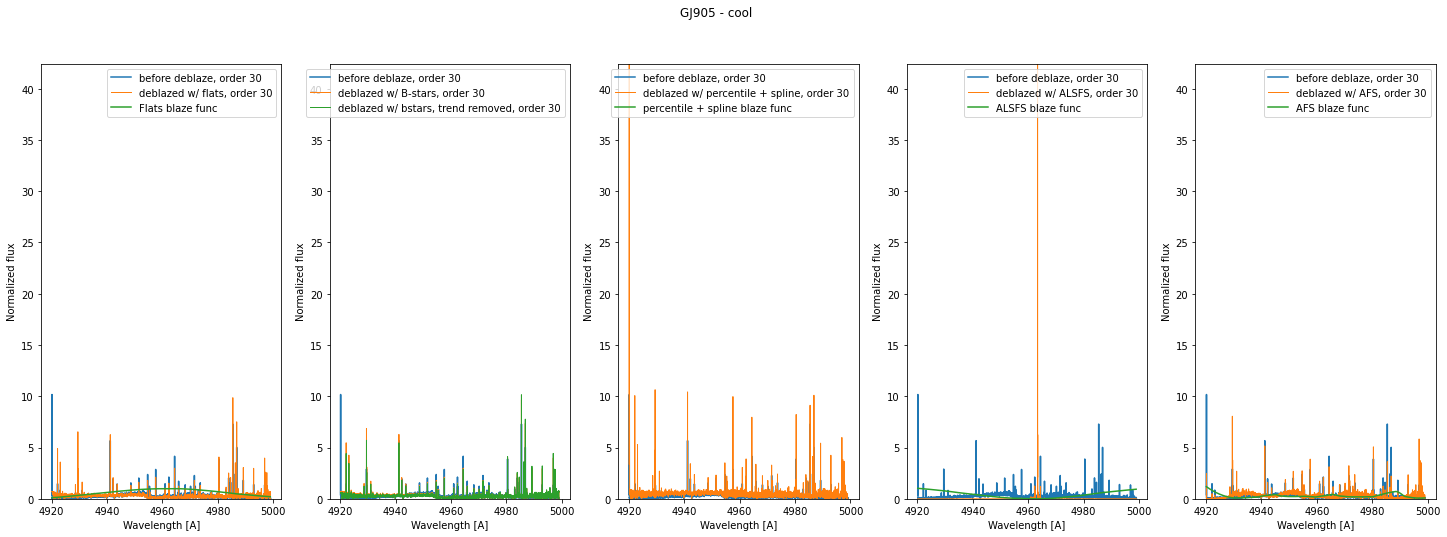

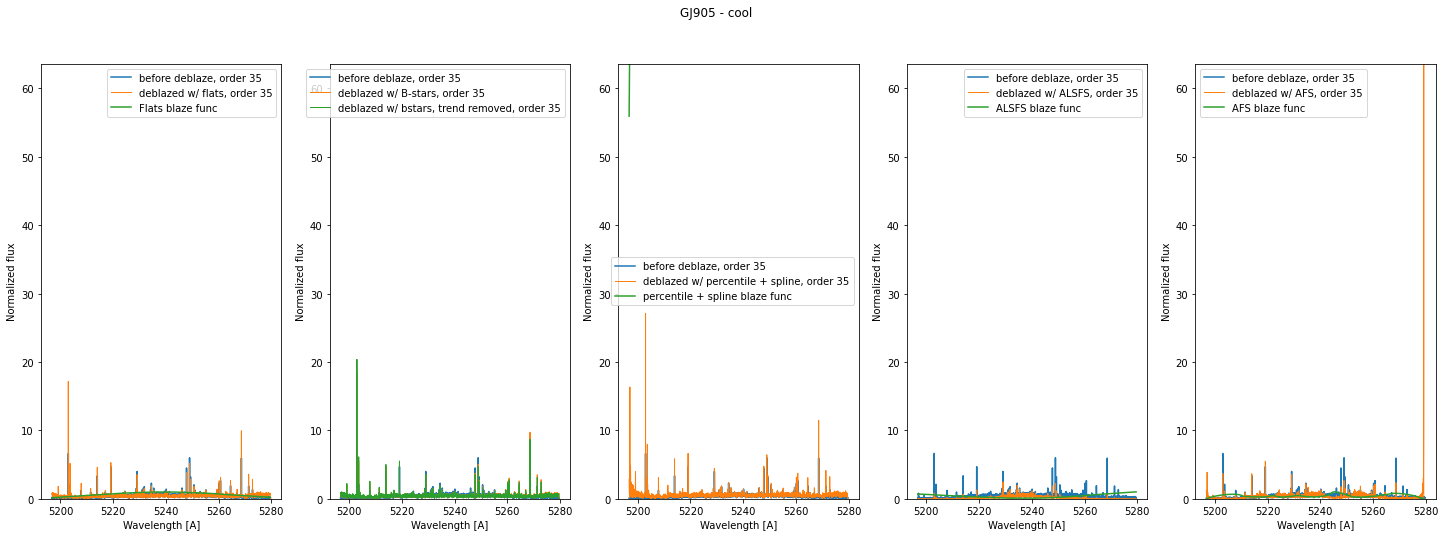

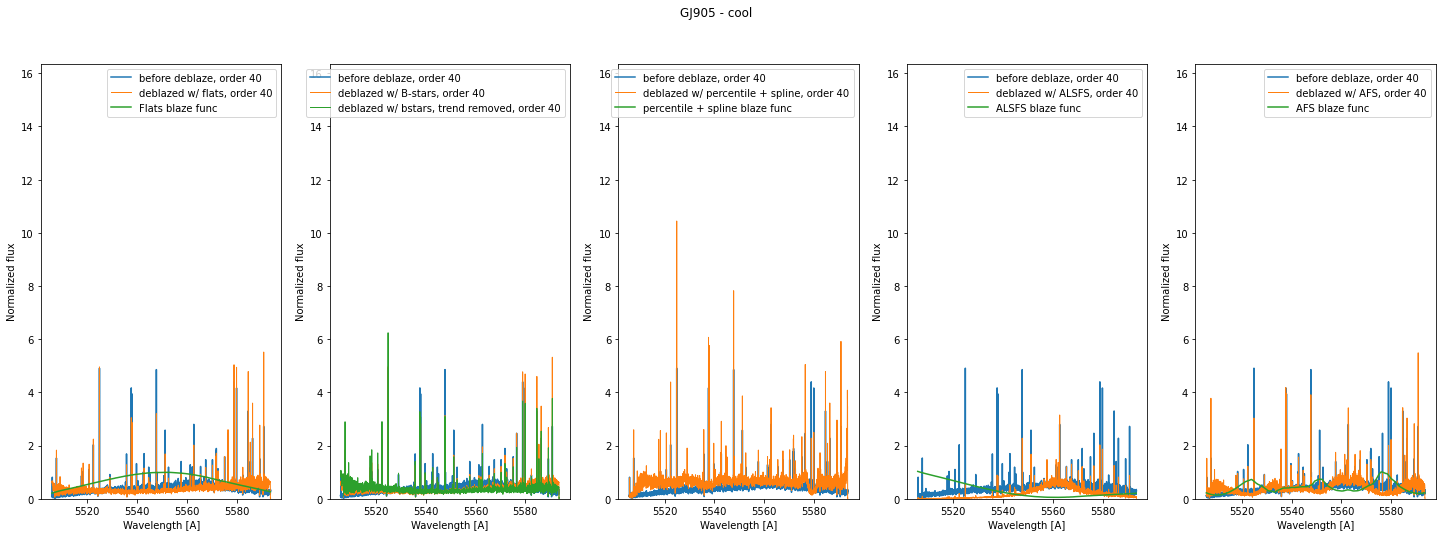

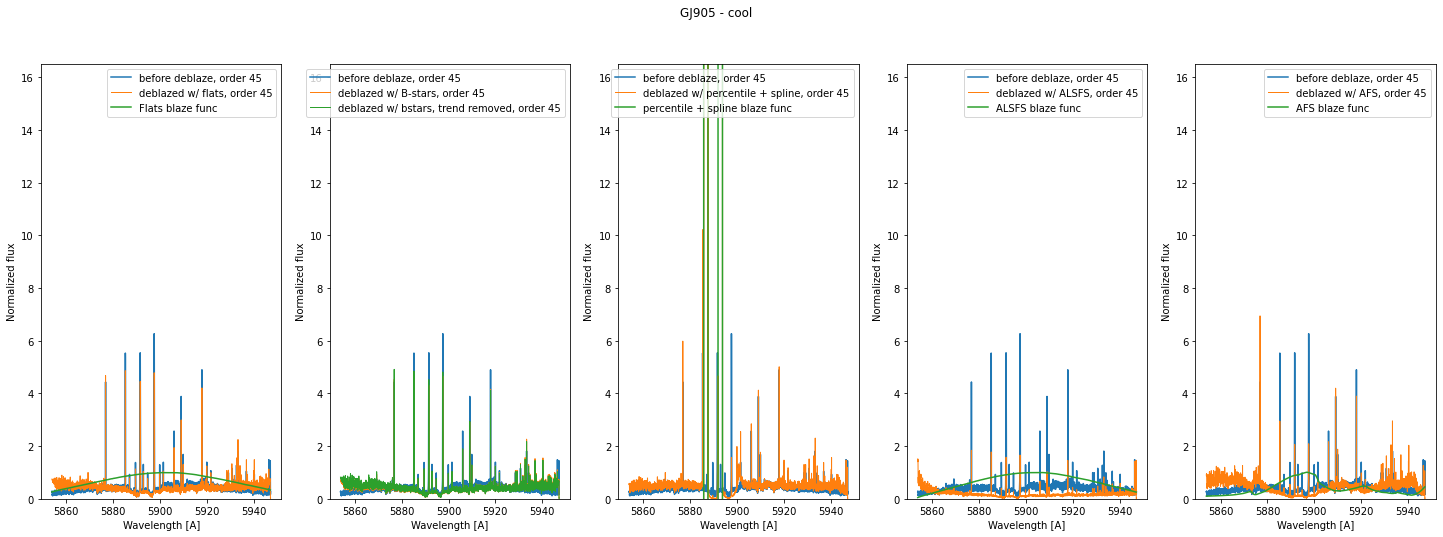

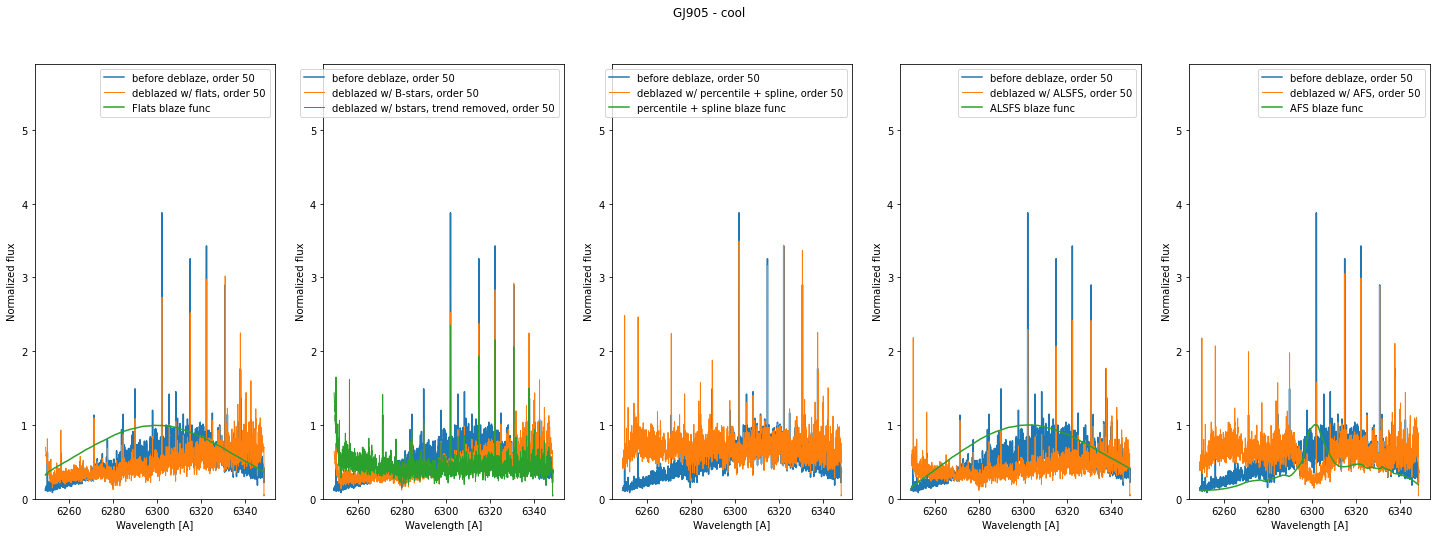

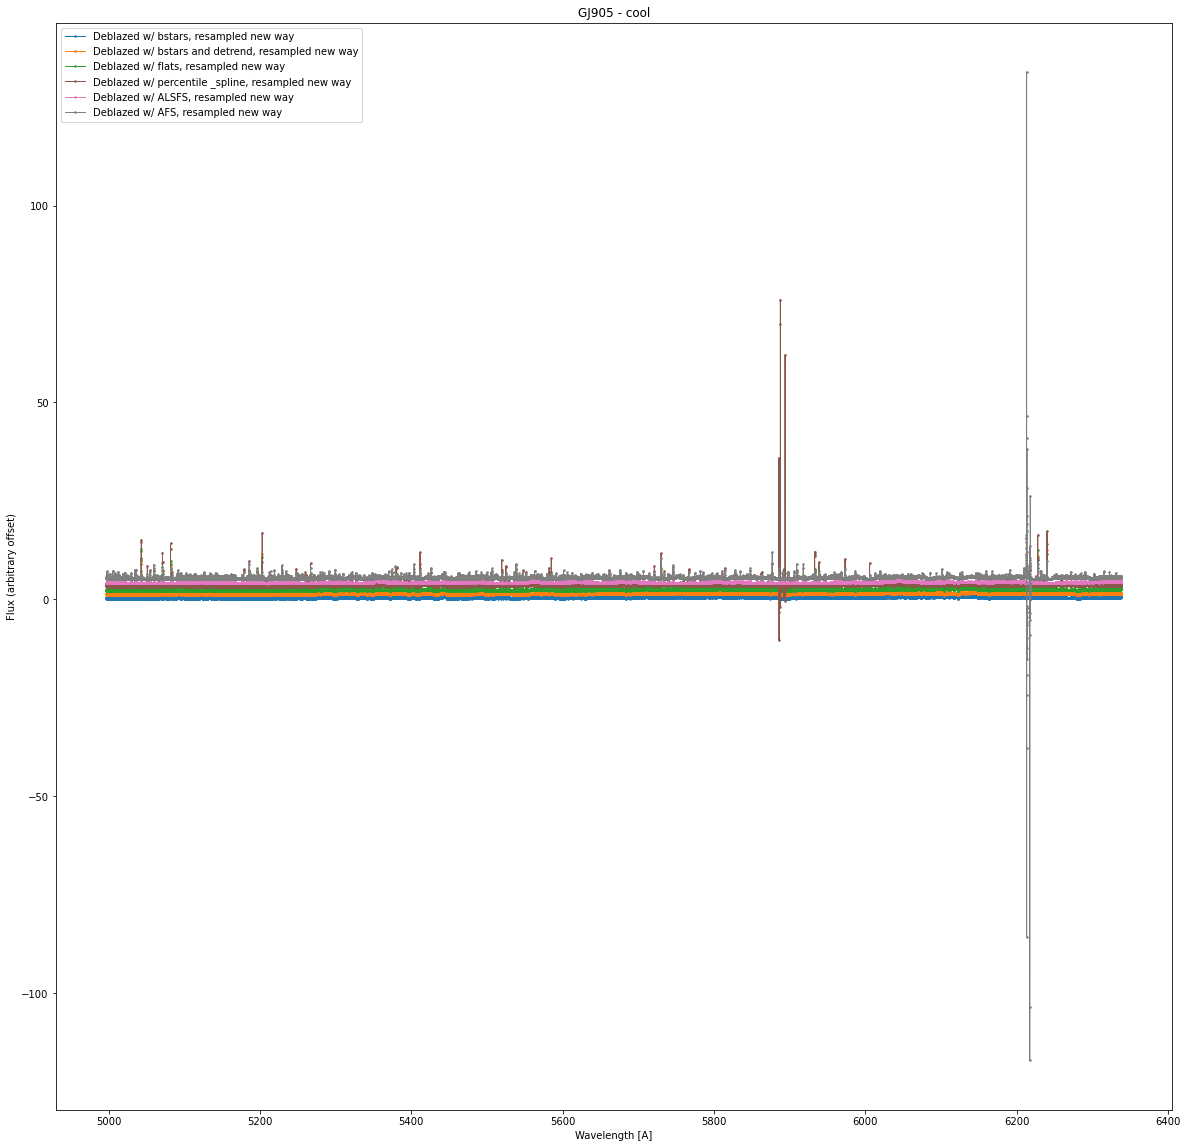

In [6]:
path_name = '/datag/blpd0/datax/apf/'
file_list = GJ905
name = 'GJ905 - cool'
print('*-------------------------------- ' + str(name) + ' ---------------------------------*')
visualize_preprocessing(file_list, name)

*-------------------------------- HIP30060 - hot ---------------------------------*
Finished deblaze, order30
Finished deblaze, order31
Finished deblaze, order32
Finished deblaze, order33
Finished deblaze, order34
Finished deblaze, order35
Finished deblaze, order36
Finished deblaze, order37
Finished deblaze, order38
Finished deblaze, order39
Finished deblaze, order40
Finished deblaze, order41
Finished deblaze, order42
Finished deblaze, order43
Finished deblaze, order44
Finished deblaze, order45
Finished deblaze, order46
Finished deblaze, order47
Finished deblaze, order48
Finished deblaze, order49
Finished deblaze, order50
Finished deblaze, order51
finished deblaze
Finished rescale
Finished resample


/home/azuckerman/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/azuckerman/.local/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished r

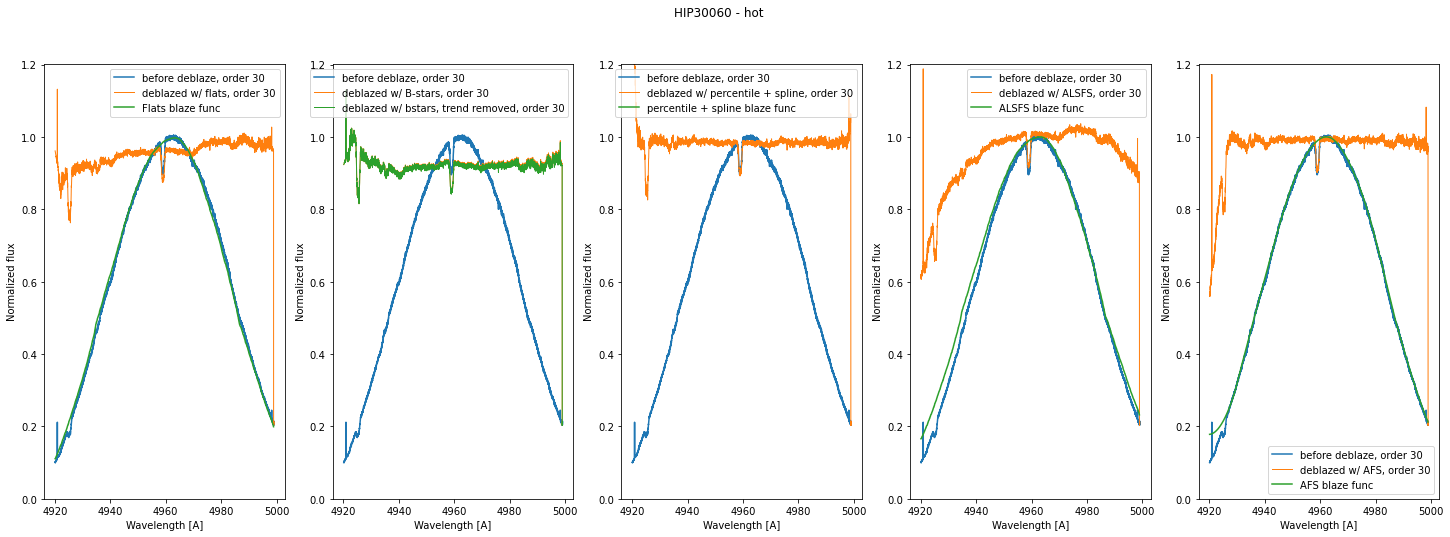

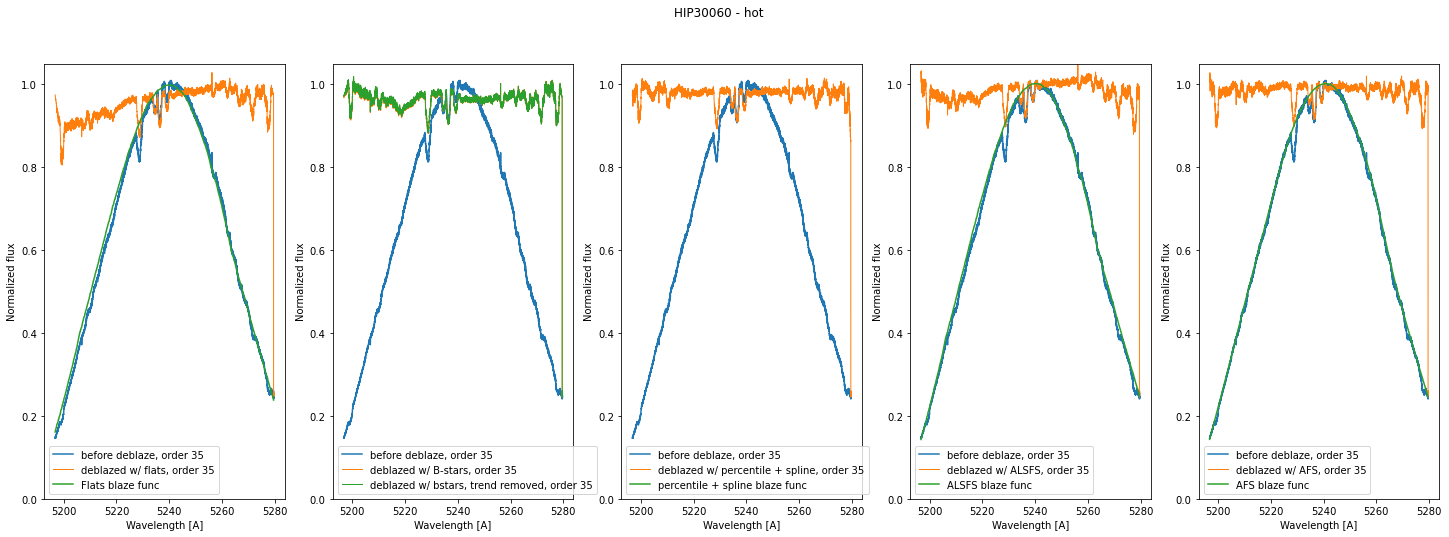

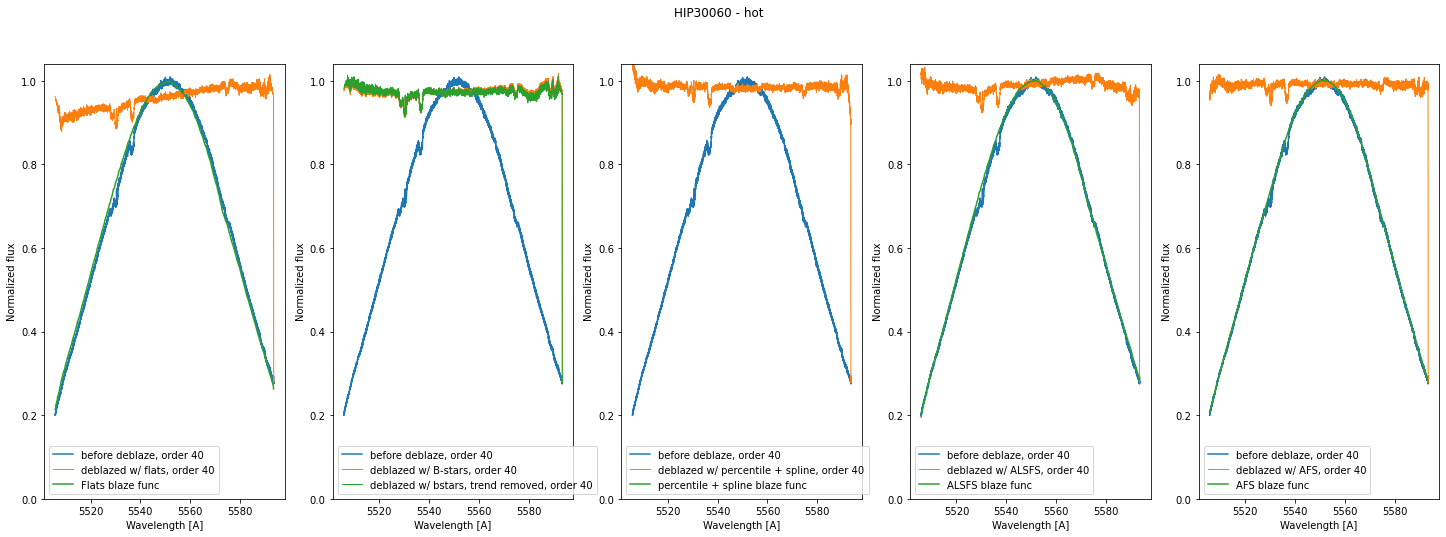

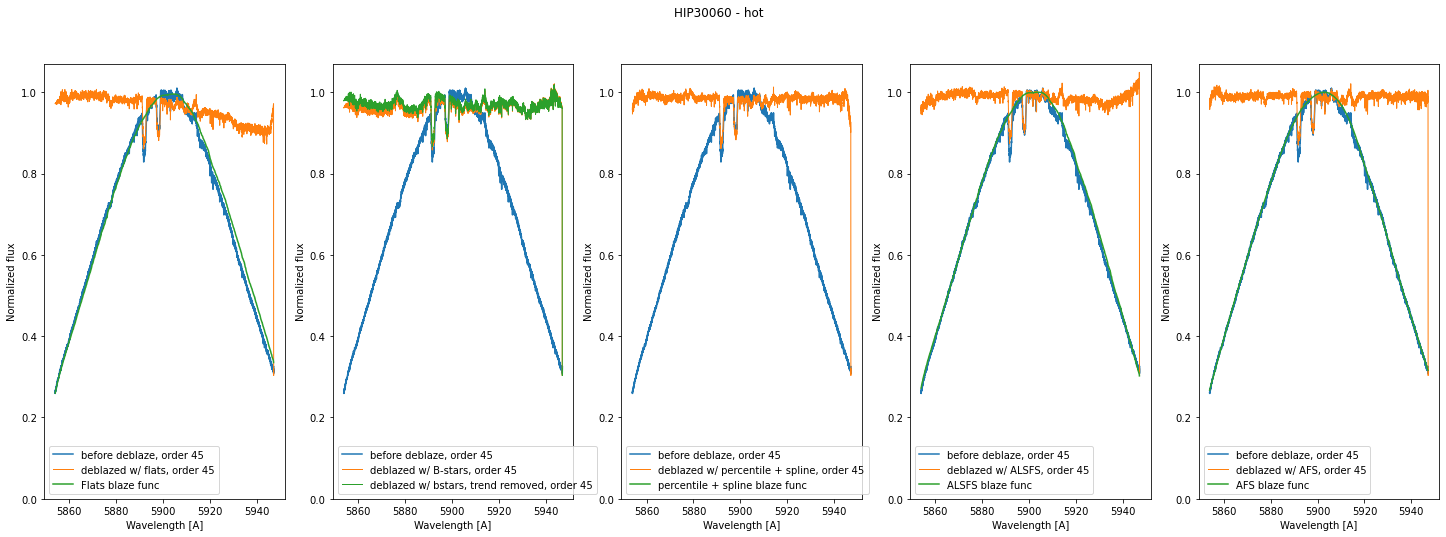

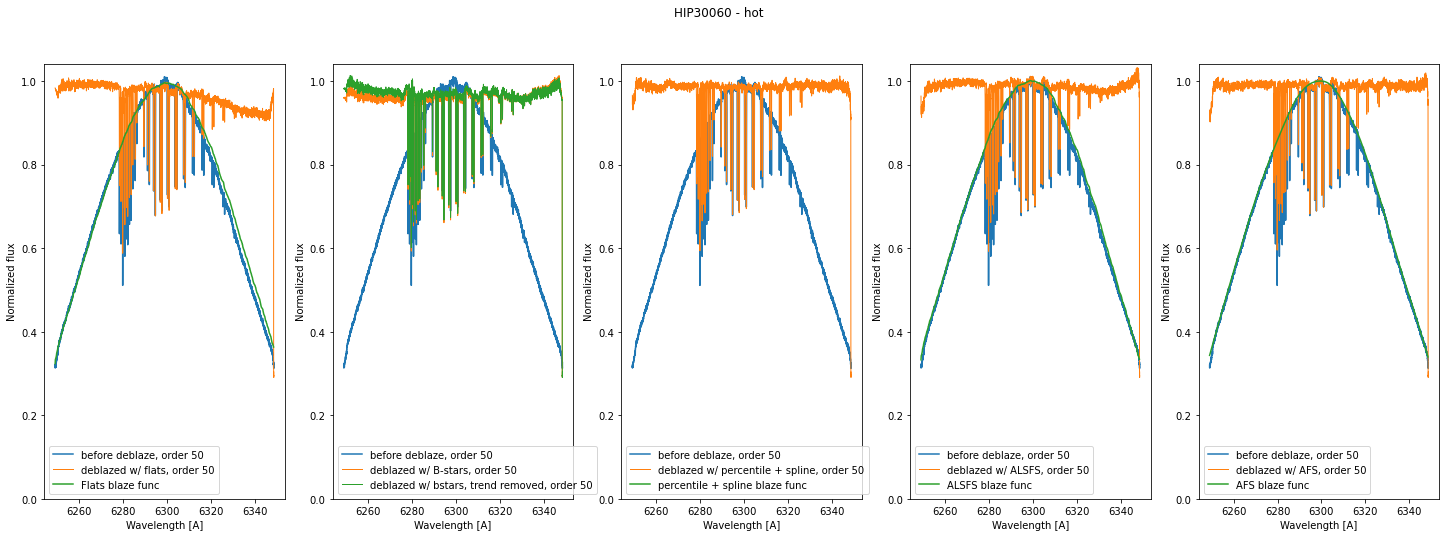

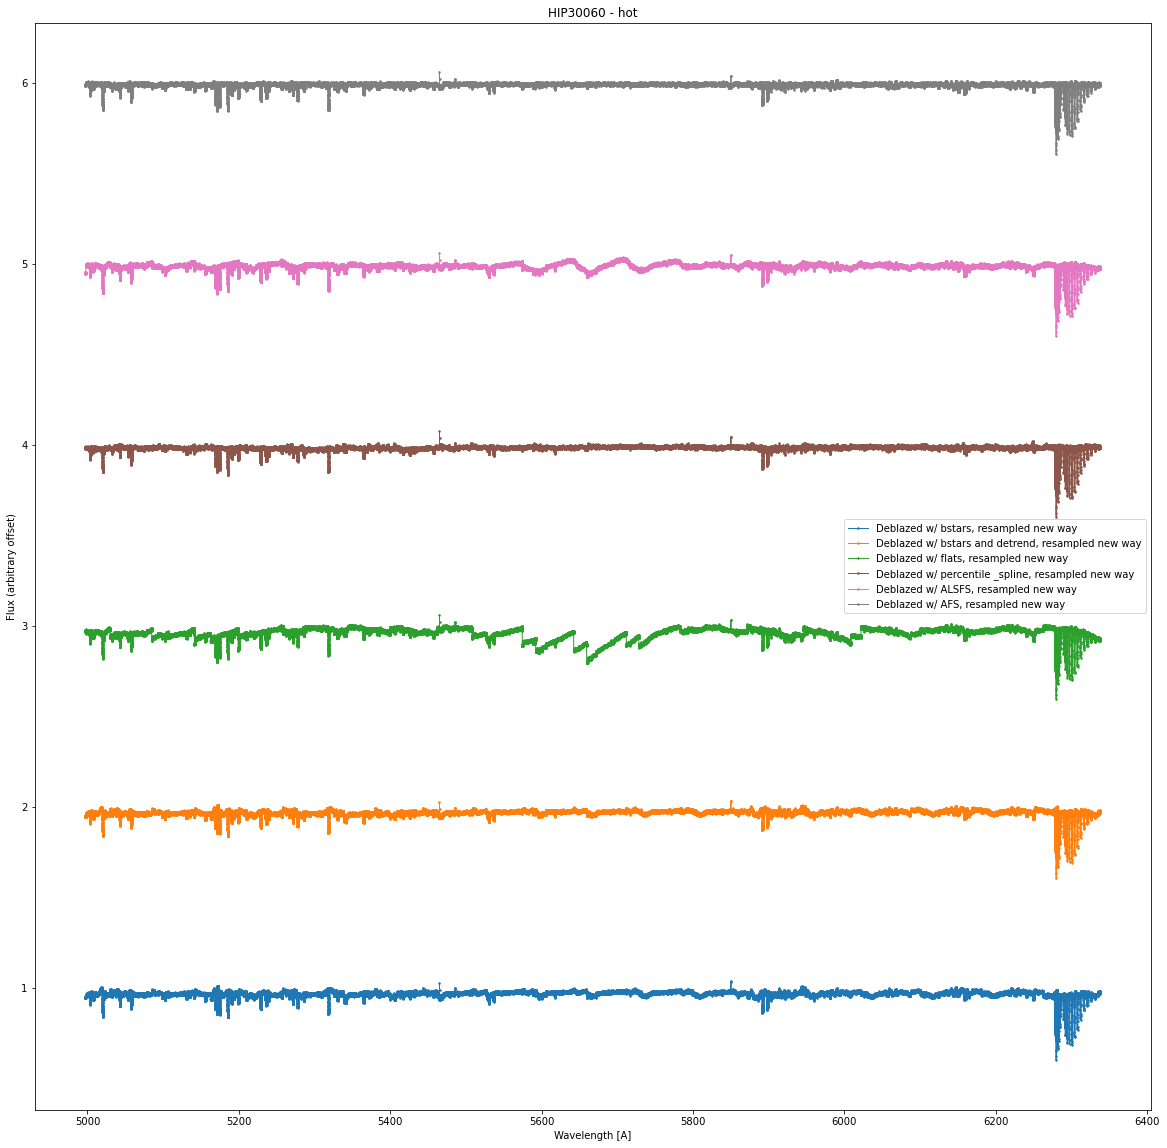

In [7]:
path_name = '/datag/blpd0/datax/apf/'
file_list = HIP30060
name = 'HIP30060 - hot'
print('*-------------------------------- ' + str(name) + ' ---------------------------------*')
visualize_preprocessing(file_list, name)

*-------------------------------- TIC8967242 - medium ---------------------------------*
Finished deblaze, order30
Finished deblaze, order31
Finished deblaze, order32
Finished deblaze, order33
Finished deblaze, order34
Finished deblaze, order35
Finished deblaze, order36
Finished deblaze, order37
Finished deblaze, order38
Finished deblaze, order39
Finished deblaze, order40
Finished deblaze, order41
Finished deblaze, order42
Finished deblaze, order43
Finished deblaze, order44
Finished deblaze, order45
Finished deblaze, order46
Finished deblaze, order47
Finished deblaze, order48
Finished deblaze, order49
Finished deblaze, order50
Finished deblaze, order51
finished deblaze
Finished rescale
Finished resample


/home/azuckerman/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/azuckerman/.local/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished resample
Finished r

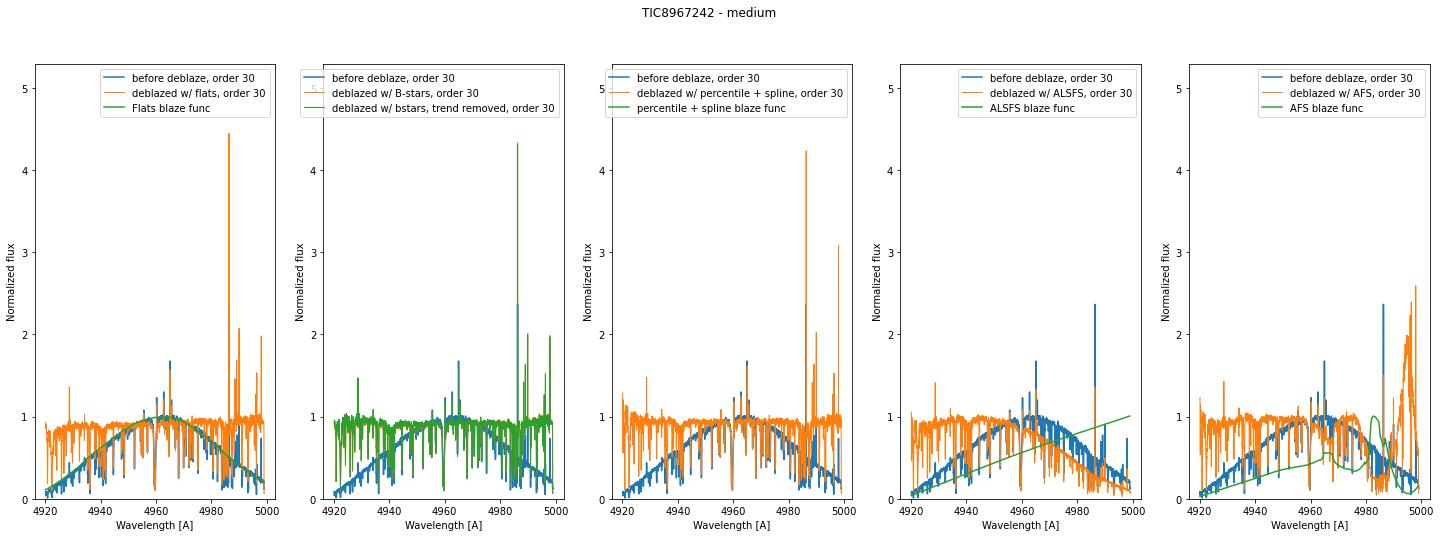

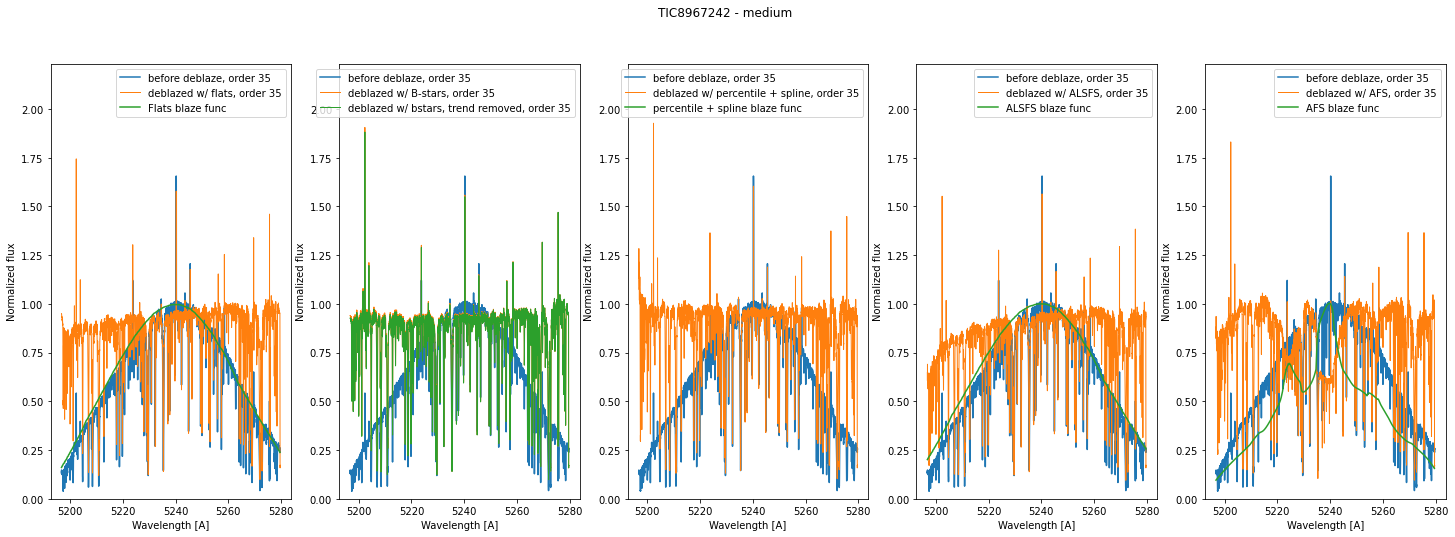

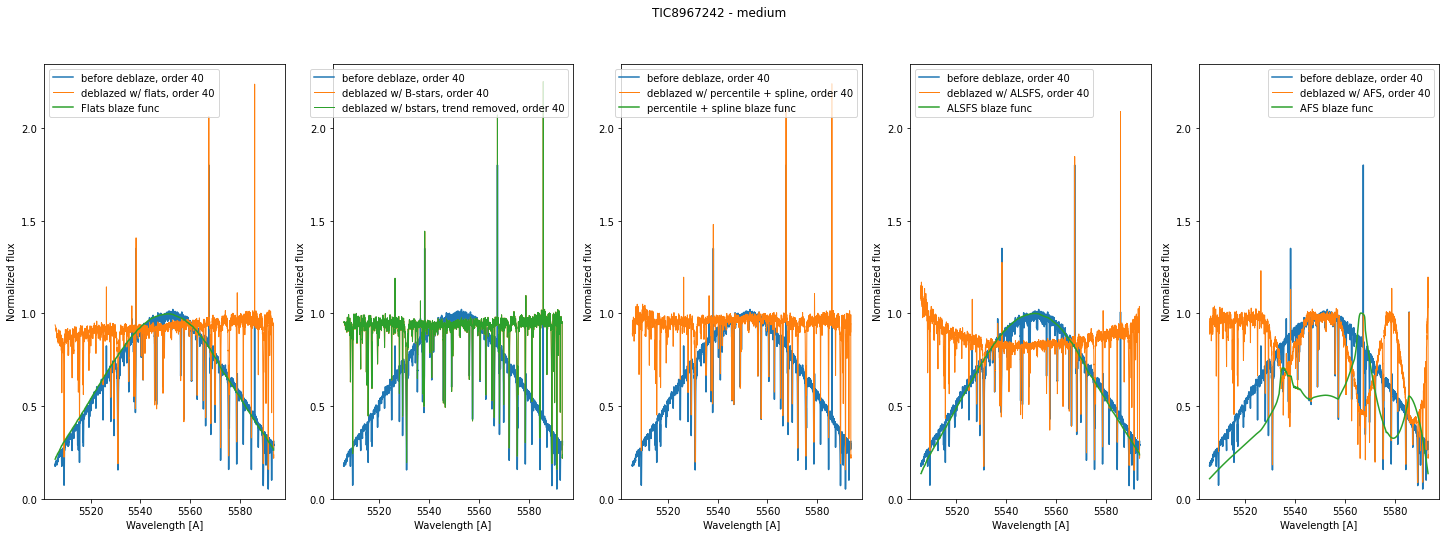

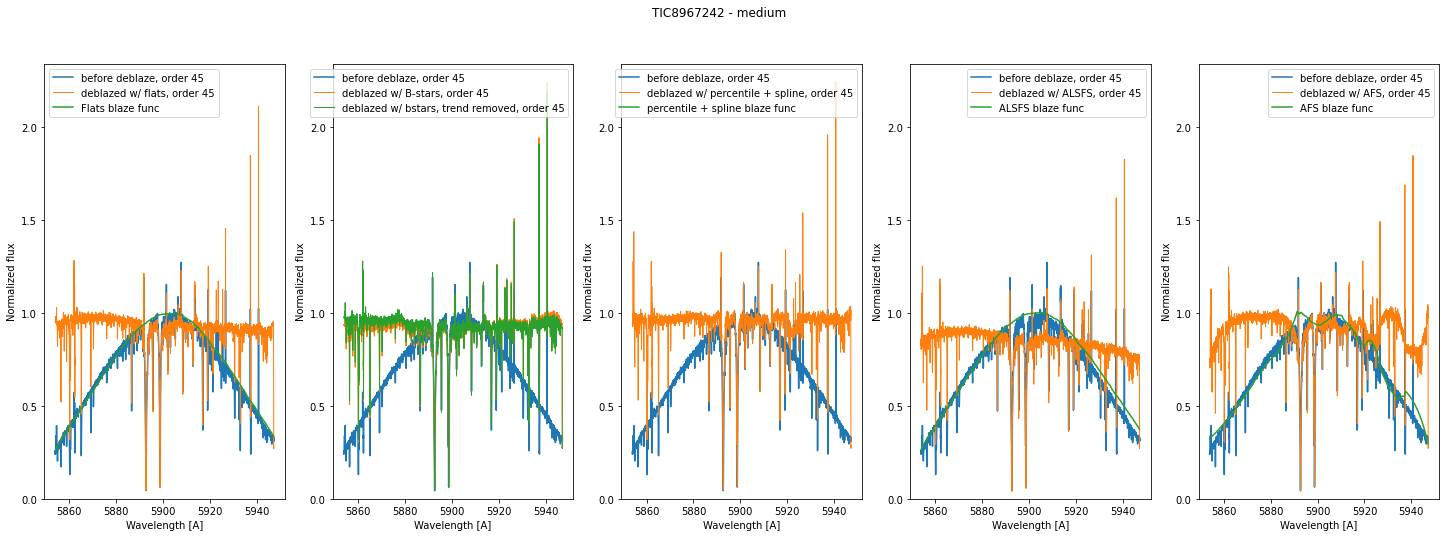

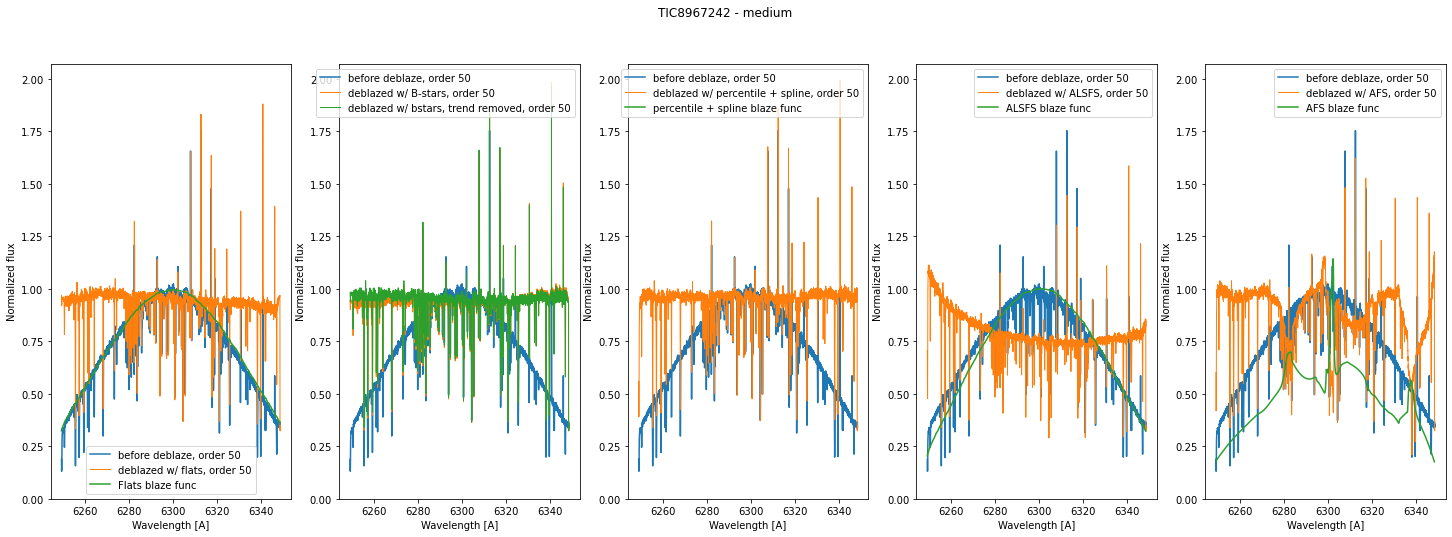

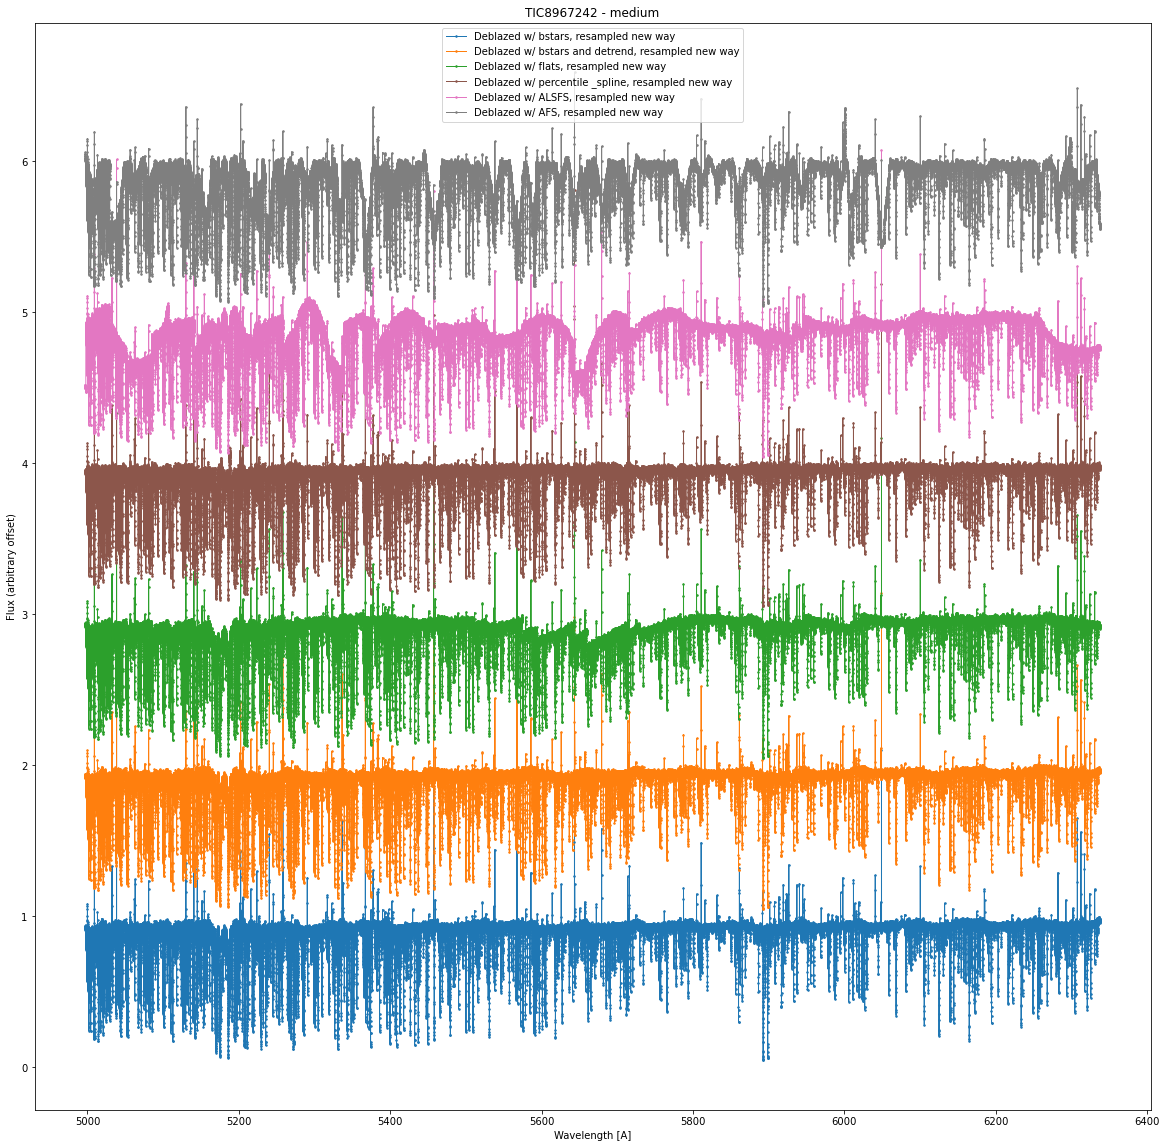

In [9]:
path_name = '/datax/scratch/hisaacson/data'
file_list = TIC8967242
name = 'TIC8967242 - medium'
print('*-------------------------------- ' + str(name) + ' ---------------------------------*')
visualize_preprocessing(file_list, name)